In [1]:
"""
Degradation-Diffusion demo.
- Generates model-based time-series tabular data
- Trains a simple denoising model
- Samples synthetic series

"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:

class BaseDegradationProcess:
    def __init__(self, length, dim):
        self.length = length
        self.dim = dim

    def generate_episode(self, x0):
        """
        Generate crack growth trajectories for multiple initial crack lengths.
        Args:
            x0: NumPy array of initial crack lengths (shape: (n_initial_points,) or scalar)
        Returns:
            NumPy array of shape (n_initial_points, length + 1) with crack length trajectories
        """
        # Convert x0 to NumPy array if scalar, ensure 1D for consistency
        x0 = np.atleast_1d(np.asarray(x0))
        # Initialize episode array: shape (n_initial_points, length + 1)
        episode = np.zeros((x0.shape[0], self.length + 1))
        episode[:, 0] = x0  # Set initial crack lengths
        # Iterate over cycles
        for i in range(self.length):
            episode[:, i + 1] = episode[:, i] + self.xdot(episode[:, i])
        return episode

class ParisLawDegradation(BaseDegradationProcess):
    """
    Paris–Erdogan fatigue crack growth model.
    Parameters:
        C: Paris law constant (m/cycle)/(MPa*sqrt(m))^m
        m: Paris law exponent
        delta_sigma: Stress range (MPa)
        beta: Geometry factor
    """
    def __init__(self, length, dim, C=1e-12, m=3, delta_sigma=100, beta=1):
        super().__init__(length, dim)
        self.C = C
        self.m = m
        self.delta_sigma = delta_sigma
        self.beta = beta

    def delta_K(self, a):
        """
        Calculate stress intensity factor range for an array of crack lengths.
        Args:
            a: NumPy array of crack lengths (m) or scalar
        Returns:
            NumPy array of Delta K values (MPa*sqrt(m))
        """
        a = np.atleast_1d(np.asarray(a))  # Ensure input is array
        return self.delta_sigma * np.sqrt(np.pi * a) * self.beta

    def xdot(self, a):
        """
        Calculate crack growth rate (da/dN) using Paris' law for an array of crack lengths.
        Args:
            a: NumPy array of crack lengths (m) or scalar
        Returns:
            NumPy array of crack growth rates (m/cycle)
        """
        a = np.atleast_1d(np.asarray(a))  # Ensure input is array
        return self.C * (self.delta_K(a) ** self.m)

In [3]:
paris1 = ParisLawDegradation(length=100, dim=1, C=1e-8)
episodes1 = paris1.generate_episode(x0=np.random.randn(300000)*0.0001+0.005)  # Initial crack lengths in meters

paris2 = ParisLawDegradation(length=100, dim=1, C=1e-9)
episodes2 = paris2.generate_episode(x0=np.random.randn(300000)*0.0001+0.003)  # Initial crack lengths in meters

episodes = np.concatenate([episodes1, episodes2], axis=0)

In [4]:
episodes.shape

(600000, 101)

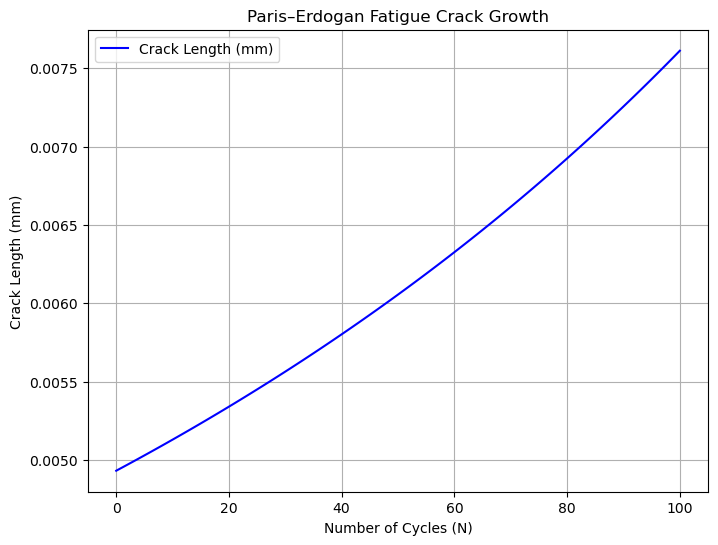

In [ ]:

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(episodes[0], 'b-', label='Crack Length (mm)')
plt.xlabel('Number of Cycles (N)')
plt.ylabel('Crack Length (mm)')
plt.title('Paris–Erdogan Fatigue Crack Growth')
plt.grid(True)
plt.legend()
plt.show()



In [20]:
# Normalize data
data = torch.tensor(episodes, dtype=torch.float32)
mean_X = torch.mean(data)
std_X = torch.std(data)
X = (data - mean_X) / std_X


In [21]:
std_X

tensor(0.0017)

In [24]:
torch.std(X)

tensor(1.)

In [8]:
# -----------------------------
# 2. Define forward diffusion
# -----------------------------
def q_sample(x0, t, noise):
    """
    Diffuse the data (add Gaussian noise) at step t.
    """
    # Linear beta schedule
    betas = torch.linspace(1e-4, 0.02, steps=T)
    alphas = 1.0 - betas
    alphas_bar = torch.cumprod(alphas, dim=0)

    sqrt_ab = torch.sqrt(alphas_bar[t])[:, None]
    sqrt_one_minus_ab = torch.sqrt(1 - alphas_bar[t])[:, None]

    return sqrt_ab * x0 + sqrt_one_minus_ab * noise


In [9]:
# -----------------------------
# 3. Simple denoising model
# -----------------------------
class DenoiseMLP(nn.Module):
    def __init__(self, dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim)
        )

    def forward(self, x, t):
        # append time embedding (scaled)
        t = t.float().unsqueeze(1) / T
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)


In [10]:
# -----------------------------
# 4. Training loop
# -----------------------------
T = 100  # number of diffusion steps
model = DenoiseMLP(dim=X.shape[1])
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(2000):
    idx = torch.randint(0, X.shape[0], (32,))
    x0 = X[idx]
    t = torch.randint(0, T, (32,))
    noise = torch.randn_like(x0)*0.1
    xt = q_sample(x0, t, noise)

    pred_noise = model(xt, t)
    loss = loss_fn(pred_noise, noise)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

Epoch 0, Loss 0.0200
Epoch 50, Loss 0.0100
Epoch 100, Loss 0.0097
Epoch 150, Loss 0.0097
Epoch 200, Loss 0.0102
Epoch 250, Loss 0.0101
Epoch 300, Loss 0.0101
Epoch 350, Loss 0.0099
Epoch 400, Loss 0.0096
Epoch 450, Loss 0.0096
Epoch 500, Loss 0.0098
Epoch 550, Loss 0.0104
Epoch 600, Loss 0.0096
Epoch 650, Loss 0.0102
Epoch 700, Loss 0.0095
Epoch 750, Loss 0.0098
Epoch 800, Loss 0.0100
Epoch 850, Loss 0.0101
Epoch 900, Loss 0.0098
Epoch 950, Loss 0.0099
Epoch 1000, Loss 0.0093
Epoch 1050, Loss 0.0096
Epoch 1100, Loss 0.0094
Epoch 1150, Loss 0.0092
Epoch 1200, Loss 0.0096
Epoch 1250, Loss 0.0093
Epoch 1300, Loss 0.0093
Epoch 1350, Loss 0.0098
Epoch 1400, Loss 0.0093
Epoch 1450, Loss 0.0091
Epoch 1500, Loss 0.0088
Epoch 1550, Loss 0.0088
Epoch 1600, Loss 0.0090
Epoch 1650, Loss 0.0090
Epoch 1700, Loss 0.0092
Epoch 1750, Loss 0.0090
Epoch 1800, Loss 0.0095
Epoch 1850, Loss 0.0087
Epoch 1900, Loss 0.0088
Epoch 1950, Loss 0.0088


In [11]:
# -----------------------------
# 5. Sampling new synthetic data
# -----------------------------
@torch.no_grad()
def p_sample_loop(n_samples=10):
    x = torch.randn(n_samples, X.shape[1])*0.1
    betas = torch.linspace(1e-6, 0.02, steps=T)
    alphas = 1.0 - betas
    alphas_bar = torch.cumprod(alphas, dim=0)

    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t)
        noise_pred = model(x, t_batch)
        alpha = alphas[t]
        alpha_bar = alphas_bar[t]

        x = (1 / torch.sqrt(alpha)) * (
            x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * noise_pred
        )
        if t > 0:
            x += torch.sqrt(betas[t]) * torch.randn_like(x)*0.01
    return x

synthetic = p_sample_loop(5).numpy()
# synthetic = scaler.inverse_transform(synthetic)


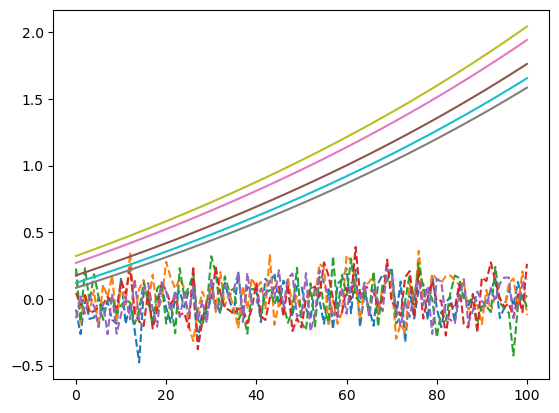

In [17]:
plt.plot(synthetic[0:5].T, '--')
plt.plot(X[:5].T)